# MMS210: Connected fleets in data-driven engineering

### Lab work: Physical-guided ML Eco-driving System Design 

Group 11: Fanxiang Liao, Xiance Wu, Jiang Fan, Chunqiu Xia, Boxuan Wu, Chaojie Lu, Jingyu Wang

First of all, let us import some libs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
from geopy.distance import geodesic
import warnings
import logging
from datetime import datetime
import json
import os

Then, prepare the log file and basic parameters for later use.

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')
GRAVITY = 9.81
MAX_TIME_DIFF = 5_000_000          
MAX_SAMPLES = 100_000
VERSION = "2.1"

: 

: 

: 

## Class: EcoDrivingAnalyzer

`EcoDrivingAnalyzer` is the central class designed to encapsulate all core functionalities of the eco-driving analysis pipeline. It integrates methods for data loading, preprocessing, synchronization, feature extraction, behavior clustering, energy modeling, and visualization. By orchestrating the entire workflow within one class, it ensures modularity, ease of maintenance, and extendibility for future improvements.

### Methods Included:
- **Initialization (`__init__`)**:  
  Sets initial parameters, file paths, and configuration settings for the analysis.

- **Data Loading and Parsing** (`load_data`, `parse_gps`, `parse_accelerometer`, `parse_gyroscope`):  
  Imports raw sensor data and performs preliminary parsing and filtering.

- **Feature Extraction** (`calculate_features`, `extract_acceleration_features`, `extract_gps_features`, `extract_gyro_features`):  
  Computes relevant features necessary for subsequent analysis, such as speed, acceleration, jerk, and turning rates.

- **Synchronization and Energy Modeling** (`synchronize_data`, `calculate_energy_efficiency`, `model_energy`):  
  Aligns GPS and accelerometer data in time and calculates driving efficiency and energy-related metrics.

- **Behavior Clustering and Event Detection** (`detect_hard_brakes`, `cluster_driving_behaviors`, `apply_pca`, `calculate_driver_scores`):  
  Categorizes driving behavior through clustering methods and identifies significant driving events like hard brakes.

- **Visualization and Reporting** (`generate_visualizations`, `plot_speed_profile`, `plot_clusters`, `save_report`):  
  Produces visual interpretations of results and compiles findings into structured reports.

In [ ]:
class EcoDrivingAnalyzer:
    """Main class for eco-driving analysis (µs timestamps)."""

    def __init__(self, config=None):
        self.config = config or self._default_config()
        self.raw_data = {}
        self.processed_data = None
        self.features = {}
        self.results = {}
        self.time_offset = None
        logger.info(f"EcoDrivingAnalyzer v{VERSION} initialized (microsecond timestamps)")

    def _default_config(self):
        return {
            "hard_brake_threshold": -2.5,
            "speed_drop_threshold": 8,
            "min_brake_speed": 15,
            "energy_model": {
                "vehicle_mass": 2500,
                "drag_coefficient": 0.28,
                "frontal_area": 2.54,
                "rolling_resistance": 0.012,
            },
            "clustering": {"n_clusters": 3, "features": ["speed", "acceleration", "jerk", "turning_rate"]},
        }

    def parse_sensor_data(self, file_path):
        """Parse sensor CSV file (microsecond resolution)."""
        logger.info(f"Parsing sensor data from {file_path}")
        gps_rows, acc_rows, gyro_rows, rot_rows = [], [], [], []
        total_rows = 0
        try:
            with open(file_path, "r") as file:
                for line in file:
                    values = line.strip().split(",")
                    if len(values) < 2:
                        continue
                    try:
                        data_type = int(values[0])
                    except ValueError:
                        continue
                    if data_type == 0 and len(values) >= 6:
                        gps_rows.append(values)
                    elif data_type == 1 and len(values) >= 5:
                        acc_rows.append(values)
                    elif data_type == 2 and len(values) >= 5:
                        gyro_rows.append(values)
                    elif data_type == 3 and len(values) >= 6:
                        rot_rows.append(values)
                    total_rows += 1
                    if total_rows >= MAX_SAMPLES:
                        break
            logger.info(f"Parsed {total_rows} lines from {file_path}")
        except Exception as e:
            logger.error(f"Error reading file: {e}")
            return False

        if gps_rows:
            print("\n=== GPS Data Parsing ===")
            print(f"Raw GPS rows: {len(gps_rows)}")
            print(f"Sample: {gps_rows[0]}")
            gps_data = []
            for row in gps_rows:
                try:
                    if len(row) >= 6:
                        gps_data.append(
                            [
                                int(row[0]),
                                int(row[1]),
                                float(row[2]),
                                float(row[3]),
                                float(row[4]),
                                float(row[5]),
                                int(row[6]) if len(row) > 6 else 12,
                            ]
                        )
                except (ValueError, IndexError):
                    continue
            if gps_data:
                gps_df = pd.DataFrame(
                    gps_data,
                    columns=[
                        "data_type",
                        "timestamp",
                        "latitude",
                        "longitude",
                        "altitude",
                        "speed_kmh",
                        "satellites",
                    ],
                )

                if gps_df["timestamp"].iloc[0] < 1e11:      # 10 digits means seconds
                    logger.warning("GPS timestamps appear to be in seconds, upscaling ×1e6")
                    gps_df["timestamp"] = gps_df["timestamp"] * 1_000_000


                gps_df["speed_ms"] = gps_df["speed_kmh"] / 3.6
                if self.time_offset is None:
                    self.time_offset = gps_df["timestamp"].min()
                gps_df["relative_time_s"] = (gps_df["timestamp"] - self.time_offset) / 1_000_000.0
                print("GPS data quality:")
                print(f"  points: {len(gps_df)}")
                print(f"  duration: {gps_df['relative_time_s'].max():.1f} s")
                print(f"  speed range: {gps_df['speed_kmh'].min():.1f}-{gps_df['speed_kmh'].max():.1f} km/h")
                print(
                    f"  lat span: {gps_df['latitude'].max()-gps_df['latitude'].min():.6f}°, "
                    f"lon span: {gps_df['longitude'].max()-gps_df['longitude'].min():.6f}°"
                )
                gps_df = gps_df[gps_df["speed_kmh"] <= 200]
                gps_df = gps_df[gps_df["latitude"].between(-90, 90)]
                gps_df = gps_df[gps_df["longitude"].between(-180, 180)]
                self.raw_data["gps"] = gps_df

        if acc_rows:
            print("\n=== Accelerometer Data Parsing ===")
            print(f"Raw accelerometer rows: {len(acc_rows)}")
            print(f"Sample: {acc_rows[0]}")
            acc_data = []
            for row in acc_rows:
                try:
                    if len(row) >= 5:
                        acc_data.append(
                            [
                                int(row[0]),
                                int(row[1]),
                                int(row[2]),
                                float(row[3]),
                                float(row[4]),
                                float(row[5]) if len(row) > 5 else 0.0,
                            ]
                        )
                except (ValueError, IndexError):
                    continue
            if acc_data:
                acc_df = pd.DataFrame(
                    acc_data, columns=["data_type", "timestamp", "timestamp_us", "x", "y", "z"]
                )
                if acc_df["timestamp"].iloc[0] < 1e11:          # seconds
                    acc_df["full_timestamp"] = (acc_df["timestamp"] * 1_000_000
                                                + acc_df["timestamp_us"])
                else:                                           # already µs
                    acc_df["full_timestamp"] = acc_df["timestamp"] + acc_df["timestamp_us"]

                if self.time_offset is None:
                    self.time_offset = acc_df["full_timestamp"].min()
                acc_df["relative_time_s"] = (acc_df["full_timestamp"] - self.time_offset) / 1_000_000.0
                print("Accelerometer data quality:")
                print(f"  points: {len(acc_df)}")
                print(f"  duration: {acc_df['relative_time_s'].max():.1f} s")
                max_acc = max(
                    acc_df["x"].abs().max(), acc_df["y"].abs().max(), acc_df["z"].abs().max()
                )
                print(f"  max raw acceleration: {max_acc:.2f}")
                if max_acc > 50:
                    scale_factor = 1000.0 if max_acc > 1000 else 10.0
                    acc_df[["x", "y", "z"]] = acc_df[["x", "y", "z"]] / scale_factor
                    print(
                        f"  scaled acceleration range: {acc_df['x'].min():.2f}-"
                        f"{acc_df['x'].max():.2f}"
                    )
                acc_df["magnitude"] = np.sqrt(
                    acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2
                )
                self.raw_data["acc"] = acc_df

        if gyro_rows:
            print("\n=== Gyroscope Data Parsing ===")
            gyro_data = []
            for row in gyro_rows:
                try:
                    if len(row) >= 5:
                        gyro_data.append(
                            [
                                int(row[0]),
                                int(row[1]),
                                int(row[2]),
                                float(row[3]),
                                float(row[4]),
                                float(row[5]) if len(row) > 5 else 0.0,
                            ]
                        )
                except (ValueError, IndexError):
                    continue
            if gyro_data:
                gyro_df = pd.DataFrame(
                    gyro_data, columns=["data_type", "timestamp", "timestamp_us", "x", "y", "z"]
                )

                if gyro_df["timestamp"].iloc[0] < 1e11:
                    gyro_df["full_timestamp"] = (gyro_df["timestamp"] * 1_000_000
                                                + gyro_df["timestamp_us"])
                else:
                    gyro_df["full_timestamp"] = gyro_df["timestamp"] + gyro_df["timestamp_us"]
                
                if self.time_offset is None:
                    self.time_offset = gyro_df["full_timestamp"].min()
                gyro_df["relative_time_s"] = (gyro_df["full_timestamp"] - self.time_offset) / 1_000_000.0
                gyro_df["turning_rate"] = gyro_df["z"].abs()
                print(f"  points: {len(gyro_df)}")
                print(
                    f"  z-axis rate range: {gyro_df['z'].min():.3f}-{gyro_df['z'].max():.3f} rad/s"
                )
                self.raw_data["gyro"] = gyro_df
        return True

    def extract_driving_features(self):
        """Extract route, acceleration, jerk and turning features."""
        logger.info("Extracting driving features")
        if "gps" in self.raw_data and not self.raw_data["gps"].empty:
            gps_df = self.raw_data["gps"].copy().sort_values("timestamp").reset_index(drop=True)
            print("\n=== GPS Feature Extraction ===")
            distances, gradients = [], []
            for i in range(1, len(gps_df)):
                p1 = (gps_df["latitude"].iloc[i - 1], gps_df["longitude"].iloc[i - 1])
                p2 = (gps_df["latitude"].iloc[i], gps_df["longitude"].iloc[i])
                try:
                    d = geodesic(p1, p2).meters
                except Exception:
                    d = 0
                distances.append(d)
                alt_diff = gps_df["altitude"].iloc[i] - gps_df["altitude"].iloc[i - 1]
                gradient = alt_diff / d if d > 0.5 else 0
                gradients.append(gradient)
            if distances:
                gps_df.loc[1:, "distance"] = distances
                gps_df.loc[1:, "gradient"] = gradients
            gps_df["distance"] = gps_df.get("distance", 0).fillna(0)
            gps_df["gradient"] = gps_df.get("gradient", 0).fillna(0)
            dt_values = gps_df["timestamp"].diff() / 1_000_000.0
            speed_changes_ms = gps_df["speed_ms"].diff()
            accelerations = []
            for i in range(len(gps_df)):
                if i == 0:
                    accelerations.append(0.0)
                else:
                    dt = dt_values.iloc[i]
                    speed_change = speed_changes_ms.iloc[i]
                    if 0.01 < dt < 300:
                        acc = speed_change / dt
                        acc = max(-12, min(12, acc))
                        accelerations.append(acc)
                    else:
                        accelerations.append(accelerations[-1] * 0.8 if i > 1 else 0.0)
            gps_df["acceleration"] = accelerations
            acc_nonzero = (np.array(accelerations) != 0).sum()
            print("GPS acceleration calculation:")
            print(f"  non-zero: {acc_nonzero}/{len(accelerations)}")
            if abs(max(accelerations)) < 0.01 or acc_nonzero < len(accelerations) * 0.1:
                print("Acceleration abnormal, switching to synthetic method")
                speed_smooth = (
                    gps_df["speed_ms"].rolling(window=3, center=True).mean().fillna(gps_df["speed_ms"])
                )
                speed_diff = speed_smooth.diff()
                time_diff = gps_df["relative_time_s"].diff()
                synthetic = []
                for i in range(len(gps_df)):
                    if i == 0:
                        synthetic.append(0.0)
                    else:
                        dt = time_diff.iloc[i]
                        if dt > 0:
                            acc = speed_diff.iloc[i] / dt
                            acc = max(-8, min(8, acc))
                            synthetic.append(acc)
                        else:
                            synthetic.append(0.0)
                gps_df["acceleration"] = synthetic
            self.features["route"] = gps_df
        if "acc" in self.raw_data and not self.raw_data["acc"].empty:
            acc_df = self.raw_data["acc"].copy().sort_values("full_timestamp").reset_index(drop=True)
            print("\n=== Accelerometer Feature Extraction ===")
            dt_acc = acc_df["full_timestamp"].diff() / 1_000_000.0
            magnitude_changes = acc_df["magnitude"].diff()
            jerks = []
            for i in range(len(acc_df)):
                if i == 0:
                    jerks.append(0.0)
                else:
                    dt = dt_acc.iloc[i]
                    mag_change = magnitude_changes.iloc[i]
                    if 0.001 < dt < 1.0:
                        jerk = max(-100, min(100, mag_change / dt))
                        jerks.append(jerk)
                    else:
                        jerks.append(0.0)
            acc_df["jerk"] = jerks
            if len(acc_df) > 5:
                window = min(3, len(acc_df) // 2 * 2 + 1)
                acc_df["jerk_smooth"] = (
                    savgol_filter(acc_df["jerk"], window, 1) if window >= 3 else acc_df["jerk"]
                )
            else:
                acc_df["jerk_smooth"] = acc_df["jerk"]
            self.features["behavior"] = acc_df
        if "gyro" in self.raw_data and not self.raw_data["gyro"].empty:
            self.features["turning"] = self.raw_data["gyro"].copy()
        return True

    def detect_hard_brake_events(self):
        """Detect hard-brake events."""
        logger.info("Detecting hard brake events")
        if "route" not in self.features:
            logger.warning("No route data")
            return pd.DataFrame()
        df = self.features["route"].copy()
        if len(df) > 5:
            window = min(5, len(df) // 2 * 2 + 1)
            df["speed_smooth"] = savgol_filter(df["speed_kmh"], window, 2)
        else:
            df["speed_smooth"] = df["speed_kmh"]
        df["speed_change"] = df["speed_smooth"].diff()
        time_diff_s = df["relative_time_s"].diff()
        df["speed_change_rate"] = df["speed_change"] / time_diff_s
        df["speed_change_pct"] = df["speed_change"] / (df["speed_smooth"].shift(1) + 1)
        conditions = [
            (df["speed_change"] < -5) & (df["speed_smooth"] > 10),
            (df["speed_change_pct"] < -0.20) & (df["speed_smooth"] > 8),
            (df["speed_change_rate"] < -8) & (df["speed_smooth"] > 5),
        ]
        df["hard_brake_candidate"] = np.logical_or.reduce(conditions)
        df["is_speed_peak"] = False
        df["hard_brake_refined"] = False
        for i in range(2, len(df) - 2):
            cur, prev, nxt = (
                df["speed_smooth"].iloc[i],
                df["speed_smooth"].iloc[i - 1],
                df["speed_smooth"].iloc[i + 1],
            )
            if cur > prev and cur > nxt and cur > 8:
                df.loc[i, "is_speed_peak"] = True
        for i in range(len(df)):
            if df["is_speed_peak"].iloc[i]:
                peak_speed = df["speed_smooth"].iloc[i]
                for j in range(i + 1, min(i + 6, len(df))):
                    cur_speed = df["speed_smooth"].iloc[j]
                    speed_drop = peak_speed - cur_speed
                    time_span = df["relative_time_s"].iloc[j] - df["relative_time_s"].iloc[i]
                    if speed_drop > 8 and time_span < 5:
                        df.loc[j, "hard_brake_refined"] = True
                        break
        df["hard_brake_final"] = df["hard_brake_candidate"] | df["hard_brake_refined"]
        df["hard_brake_filtered"] = False
        if df["hard_brake_final"].any():
            indices = df[df["hard_brake_final"]].index
            filtered = [indices[0]] if len(indices) > 0 else []
            for i in range(1, len(indices)):
                gap = (
                    df["relative_time_s"].iloc[indices[i]]
                    - df["relative_time_s"].iloc[indices[i - 1]]
                )
                if gap > 2.0:
                    filtered.append(indices[i])
            if filtered:
                df.loc[filtered, "hard_brake_filtered"] = True
        events = df[df["hard_brake_filtered"]]
        print("\n=== Hard Brake Detection ===")
        print(f"Detected: {len(events)} event(s)")
        self.features["route"] = df
        return events

    def synchronize_and_model_energy(self):
        """Synchronize all sensors and calculate energy consumption."""
        logger.info("Synchronizing data and modeling energy")
        if "route" not in self.features or "behavior" not in self.features:
            logger.warning("Missing required data")
            return pd.DataFrame()
        route_df = self.features["route"]
        behavior_df = self.features["behavior"]
        print("\n=== Data Synchronization ===")
        print(f"GPS points: {len(route_df)}")
        print(f"Accelerometer points: {len(behavior_df)}")
        route_times = route_df["timestamp"].values
        behavior_times = behavior_df["full_timestamp"].values
        combined_data = []
        sync_errors = 0
        perfect_matches = 0
        for _, row in route_df.iterrows():
            gps_time = row["timestamp"]
            time_diffs = np.abs(behavior_times - gps_time)
            idx = np.argmin(time_diffs)
            min_diff = time_diffs[idx]
            if min_diff == 0:
                perfect_matches += 1
            elif min_diff > MAX_TIME_DIFF:
                sync_errors += 1
                continue
            entry = {
                "timestamp": gps_time,
                "relative_time_s": row["relative_time_s"],
                "speed": row["speed_ms"],
                "speed_kmh": row["speed_kmh"],
                "acceleration": row["acceleration"],
                "gradient": row["gradient"],
                "jerk": behavior_df["jerk_smooth"].iloc[idx],
                "sync_error_us": min_diff,
            }
            if "turning" in self.features:
                turning_times = self.features["turning"]["full_timestamp"].values
                t_idx = np.argmin(np.abs(turning_times - gps_time))
                t_diff = np.abs(turning_times[t_idx] - gps_time)
                entry["turning_rate"] = (
                    self.features["turning"]["turning_rate"].iloc[t_idx]
                    if t_diff <= MAX_TIME_DIFF
                    else 0
                )
            else:
                entry["turning_rate"] = 0
            combined_data.append(entry)
        if not combined_data:
            logger.warning("No synchronized data")
            return pd.DataFrame()
        combined_df = pd.DataFrame(combined_data)
        combined_df["energy_factor"] = self._calculate_energy_consumption(combined_df)
        print("Synchronization summary:")
        print(f"  perfect: {perfect_matches}, synced: {len(combined_data)}, skipped: {sync_errors}")
        self.processed_data = combined_df
        return combined_df

    def _calculate_energy_consumption(self, df):
        cfg = self.config["energy_model"]
        mass = cfg["vehicle_mass"]
        rho = 1.225
        cd = cfg["drag_coefficient"]
        area = cfg["frontal_area"]
        cr = cfg["rolling_resistance"]
        g = GRAVITY
        power_W = np.zeros(len(df))
        for i in range(len(df)):
            v = max(0.1, df["speed"].iloc[i])
            theta = np.arctan(df["gradient"].iloc[i]) if abs(df["gradient"].iloc[i]) < 1 else 0
            f_roll = cr * mass * g * np.cos(theta)
            f_aero = 0.5 * rho * cd * area * v ** 2
            f_grad = mass * g * np.sin(theta)
            f_acc = mass * df["acceleration"].iloc[i]
            power_W[i] = max(f_roll + f_aero + f_grad + f_acc, 0) * v
        if len(df) > 1:
            dt = df["relative_time_s"].diff().fillna(1.0)
            dt = np.clip(dt, 0.01, 10.0)
        else:
            dt = np.array([1.0])
        df["energy_J"] = power_W * dt.values
        return power_W

    def cluster_driving_behaviors(self):
        """Cluster driver behaviour patterns."""
        logger.info("Clustering driving behaviours")
        if self.processed_data is None or self.processed_data.empty:
            logger.error("No processed data")
            return {}, pd.DataFrame(), np.array([])
        data = self.processed_data.copy()
        feats = self.config["clustering"]["features"]
        for col in feats + ["energy_J"]:
            if col not in data.columns:
                data[col] = 0.0
        print("\n=== Behaviour Clustering ===")
        X = data[feats].fillna(0.0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        try:
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_scaled)
        except Exception as e:
            logger.warning(f"PCA failed: {e}")
            X_pca = X_scaled[:, :2] if X_scaled.shape[1] >= 2 else np.column_stack(
                [X_scaled[:, 0], X_scaled[:, 0]]
            )
        n_clusters = min(self.config["clustering"]["n_clusters"], max(1, len(X) - 1))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_scaled)
        data["driver_cluster"] = clusters
        profiles = {}
        for cid in range(n_clusters):
            d = data[data["driver_cluster"] == cid]
            if d.empty:
                profiles[cid] = {"size": 0, "driver_type": "unknown"}
                continue
            if len(d) > 1:
                dt = d["relative_time_s"].diff().fillna(1.0)
                dt = np.clip(dt, 0.01, 10.0)
                total_time = dt.sum()
                total_dist = (d["speed"] * dt).sum() / 1000.0
            else:
                total_time = 1.0
                total_dist = 0.001
            total_energy = d["energy_J"].sum() / 3_600_000.0
            energy_eff = total_energy / max(total_dist, 0.001) * 100
            prof = {
                "size": len(d),
                "avg_speed": d["speed"].mean(),
                "std_speed": d["speed"].std(),
                "avg_acceleration": d["acceleration"].mean(),
                "std_acceleration": d["acceleration"].std(),
                "avg_jerk": d["jerk"].mean(),
                "std_jerk": d["jerk"].std(),
                "avg_turning_rate": d["turning_rate"].mean(),
                "std_turning_rate": d["turning_rate"].std(),
                "energy_efficiency": energy_eff,
                "total_time_s": total_time,
                "total_distance_km": total_dist,
            }
            abs_j, abs_a, spd, turn = (
                abs(prof["avg_jerk"]),
                abs(prof["avg_acceleration"]),
                prof["avg_speed"],
                prof["avg_turning_rate"],
            )
            if abs_j > 15.0 and abs_a > 2.0:
                prof["driver_type"] = "aggressive"
            elif turn > 0.15:
                prof["driver_type"] = "cornering"
            elif spd > 8.0 and abs_a > 1.0:
                prof["driver_type"] = "dynamic"
            elif spd < 5.0 and abs_j < 8.0:
                prof["driver_type"] = "cautious"
            elif abs_a < 0.5 and abs_j < 5.0:
                prof["driver_type"] = "efficient"
            else:
                prof["driver_type"] = "normal"
            profiles[cid] = prof
        self.processed_data = data
        return profiles, X_pca, clusters

    def generate_comprehensive_report(self):
        """Generate overall analysis report with recommendations."""
        logger.info("Generating report")
        if self.processed_data is None:
            logger.error("No processed data")
            return None
        data = self.processed_data
        total_time = data["relative_time_s"].max()
        total_dist = (data["speed"] * data["relative_time_s"].diff().fillna(1.0)).sum() / 1000.0
        avg_speed = data["speed"].mean() * 3.6
        max_speed = data["speed_kmh"].max()
        events = self.detect_hard_brake_events()
        profiles, X_pca, clusters = self.cluster_driving_behaviors()
        report = {
            "metadata": {
                "analysis_date": datetime.now().isoformat(),
                "version": VERSION,
                "data_points": len(data),
                "duration_minutes": total_time / 60,
                "total_distance_km": total_dist,
            },
            "driving_summary": {
                "max_speed_kmh": max_speed,
                "avg_speed_kmh": avg_speed,
                "total_hard_brakes": len(events),
                "hard_brakes_per_hour": len(events) / max(total_time / 3600, 0.1),
            },
            "cluster_analysis": profiles,
            "recommendations": self._generate_recommendations(profiles, events),
        }
        self.results = {
            "report": report,
            "data": data.copy(),
            "hard_brake_events": events,
            "cluster_profiles": profiles,
            "pca_data": X_pca,
            "clusters": clusters,
        }
        return report

    def _generate_recommendations(self, profiles, events):
        recs = []
        if len(events) > 3:
            recs.append(
                {
                    "category": "Safety",
                    "priority": "High",
                    "message": "Several hard-brake incidents detected in start-up phase. Maintain smoother acceleration.",
                    "impact": "Lower brake wear and better comfort",
                }
            )
        elif len(events) == 0:
            recs.append(
                {
                    "category": "Positive",
                    "priority": "Low",
                    "message": "No hard-brake events detected. Smooth driving!",
                    "impact": "Optimal brake preservation and comfort",
                }
            )
        for cid, prof in profiles.items():
            if prof["driver_type"] == "aggressive":
                recs.append(
                    {
                        "category": "Efficiency",
                        "priority": "Medium",
                        "message": f"Cluster {cid} shows aggressive behaviour. Softer acceleration can improve efficiency by 15–20 %.",
                        "impact": f"Current efficiency: {prof['energy_efficiency']:.1f} kWh/100 km",
                    }
                )
            elif prof["driver_type"] == "efficient":
                recs.append(
                    {
                        "category": "Positive",
                        "priority": "Low",
                        "message": f"Cluster {cid} demonstrates efficient driving. Excellent energy management.",
                        "impact": f"Energy efficiency: {prof['energy_efficiency']:.1f} kWh/100 km",
                    }
                )
            elif prof["driver_type"] == "cautious":
                recs.append(
                    {
                        "category": "Performance",
                        "priority": "Low",
                        "message": f"Cluster {cid} is very cautious. Slightly more dynamic acceleration when safe could improve flow.",
                        "impact": "Better traffic integration while maintaining safety",
                    }
                )
        return recs

    def visualize_results(self, save_plots=True):
        """Render a nine-panel dashboard with speed, clusters, distributions and scores."""
        if not self.results:
            logger.error("No results to visualize")
            return
        data = self.processed_data
        if data is None or not isinstance(data, pd.DataFrame):
            logger.error("Invalid data")
            return
        events = self.results["hard_brake_events"]
        profiles = self.results["cluster_profiles"]
        fig = plt.figure(figsize=(20, 16))
        # 1 Speed profile
        ax1 = plt.subplot(3, 3, 1)
        plt.plot(data["relative_time_s"] / 60, data["speed_kmh"], "b-", alpha=0.7, linewidth=2, label="Speed (km/h)")
        if not events.empty:
            plt.scatter(
                events["relative_time_s"] / 60,
                events["speed_kmh"],
                color="red",
                marker="X",
                s=100,
                zorder=5,
                label=f"Hard Brakes ({len(events)})",
            )
        plt.title("Speed Profile with Hard-Brake Events")
        plt.xlabel("Time (min)")
        plt.ylabel("Speed (km/h)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        # 2 PCA clusters
        ax2 = plt.subplot(3, 3, 2)
        sc = plt.scatter(
            self.results["pca_data"][:, 0],
            self.results["pca_data"][:, 1],
            c=self.results["clusters"],
            cmap="viridis",
            alpha=0.7,
            s=30,
        )
        plt.title("Behaviour Clusters (PCA)")
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.colorbar(sc, label="Cluster")
        plt.grid(True, alpha=0.3)
        # 3 Acceleration distribution
        ax3 = plt.subplot(3, 3, 3)
        colors = ["red", "blue", "green", "orange", "purple", "brown"]
        for cid in profiles.keys():
            d = data[data["driver_cluster"] == cid]
            if not d.empty:
                plt.hist(d["acceleration"], bins=15, alpha=0.6, density=True, label=f"Cluster {cid}", color=colors[cid % len(colors)])
        plt.title("Acceleration Distribution")
        plt.xlabel("Acceleration (m/s²)")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        # 4 Jerk distribution
        ax4 = plt.subplot(3, 3, 4)
        for cid in profiles.keys():
            d = data[data["driver_cluster"] == cid]
            if not d.empty:
                plt.hist(d["jerk"], bins=15, alpha=0.6, density=True, label=f"Cluster {cid}", color=colors[cid % len(colors)])
        plt.title("Jerk Distribution")
        plt.xlabel("Jerk (m/s³)")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        # 5 Driver-type pie
        ax5 = plt.subplot(3, 3, 5)
        type_counts = {}
        type_col = {
            "aggressive": "red",
            "dynamic": "orange",
            "cornering": "purple",
            "efficient": "green",
            "cautious": "blue",
            "normal": "cyan",
            "unknown": "gray",
        }
        for p in profiles.values():
            t = p["driver_type"]
            type_counts[t] = type_counts.get(t, 0) + 1
        plt.pie(
            type_counts.values(),
            labels=type_counts.keys(),
            colors=[type_col.get(t, "gray") for t in type_counts.keys()],
            autopct="%1.1f%%",
            startangle=90,
        )
        plt.title("Driver Type Distribution")
        # 6 Efficiency bars
        ax6 = plt.subplot(3, 3, 6)
        ids = list(profiles.keys())
        effs = [profiles[c]["energy_efficiency"] for c in ids]
        types = [profiles[c]["driver_type"] for c in ids]
        plt.bar(
            range(len(ids)),
            effs,
            color=[type_col.get(t, "gray") for t in types],
            alpha=0.8,
        )
        plt.title("Energy Efficiency by Cluster")
        plt.xlabel("Cluster")
        plt.ylabel("kWh/100 km")
        plt.xticks(range(len(ids)), [f"C{c}\n({t})" for c, t in zip(ids, types)])
        # 7 Speed-acceleration scatter
        ax7 = plt.subplot(3, 3, 7)
        sc2 = plt.scatter(
            data["speed_kmh"],
            data["acceleration"],
            c=data["driver_cluster"],
            cmap="viridis",
            alpha=0.6,
            s=20,
        )
        plt.title("Speed vs Acceleration")
        plt.xlabel("Speed (km/h)")
        plt.ylabel("Acceleration (m/s²)")
        plt.colorbar(sc2, label="Cluster")
        plt.grid(True, alpha=0.3)
        # 8 Acceleration time series
        ax8 = plt.subplot(3, 3, 8)
        sample = data.head(min(200, len(data)))
        plt.plot(sample["relative_time_s"] / 60, sample["acceleration"], "g-", alpha=0.7, linewidth=1)
        plt.title("Acceleration Time Series (first 200 pts)")
        plt.xlabel("Time (min)")
        plt.ylabel("Acceleration (m/s²)")
        plt.grid(True, alpha=0.3)
        # 9 Score dashboard
        ax9 = plt.subplot(3, 3, 9)
        events_per_hour = len(events) / max(data["relative_time_s"].max() / 3600, 0.1)
        avg_eff = np.mean([p["energy_efficiency"] for p in profiles.values()])
        safety = max(0, 100 - events_per_hour * 15)
        efficiency = max(0, 100 - max(0, avg_eff - 25) * 2)
        smoothness = 100 - min(50, np.mean([abs(p["avg_jerk"]) for p in profiles.values()]) * 2)
        overall = (safety + efficiency + smoothness) / 3
        scores, labels = [safety, efficiency, smoothness, overall], ["Safety", "Efficiency", "Smoothness", "Overall"]
        plt.bar(labels, scores, color=["red", "green", "blue", "purple"], alpha=0.7)
        plt.ylim(0, 100)
        plt.title("Eco-Driving Score Dashboard")
        for i, s in enumerate(scores):
            plt.text(i, s + 2, f"{s:.0f}", ha="center", va="bottom", fontweight="bold")
        plt.tight_layout()
        if save_plots:
            plt.savefig("eco_driving_startup_analysis.png", dpi=300, bbox_inches="tight")
            logger.info("Plot saved")
        plt.show()
        return True

    def save_results(self, output_dir="eco_driving_results"):
        """Save CSV, JSON and text report to disk."""
        if not self.results:
            logger.error("No results to save")
            return False
        os.makedirs(output_dir, exist_ok=True)
        try:
            self.results["data"].to_csv(f"{output_dir}/processed_data.csv", index=False)
            if not self.results["hard_brake_events"].empty:
                self.results["hard_brake_events"].to_csv(f"{output_dir}/hard_brake_events.csv", index=False)
            with open(f"{output_dir}/analysis_report.json", "w", encoding="utf-8") as f:
                json.dump(self.results["report"], f, indent=2, ensure_ascii=False, default=str)
            self._save_text_report(f"{output_dir}/eco_driving_report.txt")
            logger.info(f"Results saved to {output_dir}")
            return True
        except Exception as e:
            logger.error(f"Error saving results: {e}")
            return False

    def _save_text_report(self, path):
        """Write a plain-text report file."""
        with open(path, "w", encoding="utf-8") as f:
            rpt = self.results["report"]
            profiles = self.results["cluster_profiles"]
            events = self.results["hard_brake_events"]
            f.write("=" * 80 + "\n")
            f.write("ECO-DRIVING ANALYSIS REPORT (START-UP PHASE)\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Analysis date: {rpt['metadata']['analysis_date']}\n")
            f.write(f"Version: {rpt['metadata']['version']} (µs precision)\n")
            f.write(f"Data points: {rpt['metadata']['data_points']}\n")
            f.write(f"Duration: {rpt['metadata']['duration_minutes']:.1f} min\n")
            f.write(f"Distance: {rpt['metadata']['total_distance_km']:.3f} km\n\n")
            f.write("DRIVING SUMMARY\n")
            f.write("-" * 40 + "\n")
            f.write(f"Max speed: {rpt['driving_summary']['max_speed_kmh']:.1f} km/h\n")
            f.write(f"Average speed: {rpt['driving_summary']['avg_speed_kmh']:.1f} km/h\n")
            f.write(f"Hard brakes: {rpt['driving_summary']['total_hard_brakes']}\n")
            f.write(f"Hard brakes/h: {rpt['driving_summary']['hard_brakes_per_hour']:.1f}\n\n")
            f.write("CLUSTER DETAILS\n")
            f.write("-" * 40 + "\n")
            for cid, p in profiles.items():
                f.write(f"\nCluster {cid} – {p['driver_type'].upper()}\n")
                f.write(f"  Samples: {p['size']}\n")
                f.write(f"  Avg speed: {p['avg_speed']*3.6:.1f} km/h\n")
                f.write(f"  Avg acceleration: {p['avg_acceleration']:.3f} m/s²\n")
                f.write(f"  Avg jerk: {p['avg_jerk']:.3f} m/s³\n")
                f.write(f"  Avg turning rate: {p['avg_turning_rate']:.3f} rad/s\n")
                f.write(f"  Efficiency: {p['energy_efficiency']:.2f} kWh/100 km\n")
                f.write(f"  Distance: {p['total_distance_km']:.4f} km\n")
                f.write(f"  Time: {p['total_time_s']:.1f} s\n")
            f.write("\nHARD BRAKE DETAILS\n")
            f.write("-" * 40 + "\n")
            if not events.empty:
                for i, (_, ev) in enumerate(events.iterrows()):
                    f.write(
                        f"  {i+1}: {ev['relative_time_s']/60:.1f} min – "
                        f"Speed {ev['speed_kmh']:.1f} km/h, Acc {ev['acceleration']:.2f} m/s²\n"
                    )
            else:
                f.write("  None\n")
            f.write("\nRECOMMENDATIONS\n")
            f.write("-" * 40 + "\n")
            for i, rec in enumerate(rpt["recommendations"]):
                f.write(f"{i+1}. [{rec['category']} – {rec['priority']}] {rec['message']}\n")
                f.write(f"   Impact: {rec['impact']}\n\n")
            f.write("TECHNICAL NOTES\n")
            f.write("-" * 20 + "\n")
            f.write("µs timestamps; start-up phase focus; real GPS-based acceleration; instant jerk\n")

: 

: 

: 

### Function: `run_complete_eco_driving_analysis`

`run_complete_eco_driving_analysis` performs an end-to-end analysis of eco-driving behaviors. It integrates data parsing, synchronization, feature extraction, energy modeling, behavior clustering, and event detection into a streamlined workflow. This comprehensive function generates both numerical reports and visualizations to highlight driving efficiency and areas for potential improvement.


In [ ]:
def run_complete_eco_driving_analysis(data_file, config=None):
    """Convenience wrapper to execute the full pipeline."""
    print("Starting Eco-Driving Analysis System v2.1")
    analyzer = EcoDrivingAnalyzer(config)
    print("Step 1: Parsing data")
    if not analyzer.parse_sensor_data(data_file):
        print("Parsing failed"); return None
    print("Step 2: Extracting features")
    if not analyzer.extract_driving_features():
        print("Feature extraction failed"); return None
    print("Step 3: Synchronizing & energy modeling")
    combined = analyzer.synchronize_and_model_energy()
    if combined.empty:
        print("Synchronization failed"); return None
    print("Step 4: Generating report")
    if not analyzer.generate_comprehensive_report():
        print("Report generation failed"); return None
    print("Step 5: Visualization")
    analyzer.visualize_results()
    print("Step 6: Saving outputs")
    analyzer.save_results()
    print("Analysis complete!")
    return analyzer

: 

: 

: 

### Function: `validate_data_format`

`validate_data_format` ensures the integrity and correctness of the input sensor data. It verifies that each data record conforms to the expected format, including timestamp precision, sensor value ranges, and data completeness. This validation step prevents errors in downstream processing and ensures reliable analysis results.

In [ ]:
def validate_data_format(file_path, sample_lines=10):
    """Quick format checker for raw CSV files."""
    print(f"Validating data format for {file_path}")
    print("=" * 50)
    try:
        with open(file_path, "r") as f:
            lines = [f.readline().strip() for _ in range(sample_lines)]
        counts = {"gps": 0, "acc": 0, "gyro": 0, "rot": 0, "unknown": 0}
        print("Sample lines:")
        for i, line in enumerate(lines):
            if not line:
                continue
            values = line.split(",")
            print(f"  {i+1}: {line}")
            if len(values) >= 2:
                try:
                    dtype = int(values[0])
                    if dtype == 0:
                        counts["gps"] += 1
                        if len(values) < 6:
                            print(f"    GPS line has {len(values)} columns (expected ≥6)")
                    elif dtype == 1:
                        counts["acc"] += 1
                        if len(values) < 5:
                            print(f"    Acc line has {len(values)} columns (expected ≥5)")
                    elif dtype == 2:
                        counts["gyro"] += 1
                        if len(values) < 5:
                            print(f"    Gyro line has {len(values)} columns (expected ≥5)")
                    elif dtype == 3:
                        counts["rot"] += 1
                        if len(values) < 6:
                            print(f"    Rot line has {len(values)} columns (expected ≥6)")
                    else:
                        counts["unknown"] += 1
                        print(f"    Unknown data type: {dtype}")
                except ValueError:
                    counts["unknown"] += 1
                    print(f"    Invalid data type: {values[0]}")
        print("\nData type counts:")
        for k, v in counts.items():
            if v:
                print(f"  {k}: {v}")
        print("\nTimestamp check:")
        for line in lines:
            if not line:
                continue
            vals = line.split(",")
            if len(vals) >= 2:
                try:
                    ts = int(vals[1])
                    if ts > 1_000_000_000_000:
                        print(f"  µs timestamp detected: {ts}")
                    elif ts > 1_000_000_000:
                        print(f"  ms timestamp detected: {ts}")
                    else:
                        print(f"  unusual timestamp: {ts}")
                    break
                except ValueError:
                    continue
        return True
    except Exception as e:
        print(f"Error: {e}")
        return False

: 

: 

: 

### Function: `Main`

We could employ all the functions above to handle our own case.


2025-05-28 02:41:50,686 - INFO - EcoDrivingAnalyzer v2.1 initialized (microsecond timestamps)
2025-05-28 02:41:50,686 - INFO - Parsing sensor data from ts_1747221572.csv
2025-05-28 02:41:50,818 - INFO - Parsed 100000 lines from ts_1747221572.csv
2025-05-28 02:41:50,820 - WARNING - GPS timestamps appear to be in seconds, upscaling ×1e6


Starting Eco-Driving Analysis System v2.1
Step 1: Parsing data

=== GPS Data Parsing ===
Raw GPS rows: 667
Sample: ['0', '1747221671', '57.687946', '11.980719', '56.200001', '2.857636', '12']
GPS data quality:
  points: 667
  duration: 671.0 s
  speed range: 0.0-91.8 km/h
  lat span: 0.038410°, lon span: 0.017737°

=== Accelerometer Data Parsing ===
Raw accelerometer rows: 84489
Sample: ['1', '1747221671', '3809', '-1.800781', '-0.957031', '9.539062']


2025-05-28 02:41:51,129 - INFO - Extracting driving features


Accelerometer data quality:
  points: 84489
  duration: 671.0 s
  max raw acceleration: 14.90

=== Gyroscope Data Parsing ===
  points: 12051
  z-axis rate range: -0.529-0.596 rad/s
Step 2: Extracting features

=== GPS Feature Extraction ===
GPS acceleration calculation:
  non-zero: 664/667

=== Accelerometer Feature Extraction ===


2025-05-28 02:41:51,722 - INFO - Synchronizing data and modeling energy
2025-05-28 02:41:51,828 - INFO - Generating report
2025-05-28 02:41:51,830 - INFO - Detecting hard brake events
2025-05-28 02:41:51,853 - INFO - Clustering driving behaviours


Step 3: Synchronizing & energy modeling

=== Data Synchronization ===
GPS points: 667
Accelerometer points: 84489
Synchronization summary:
  perfect: 0, synced: 667, skipped: 0
Step 4: Generating report

=== Hard Brake Detection ===
Detected: 12 event(s)

=== Behaviour Clustering ===
Step 5: Visualization


2025-05-28 02:41:54,281 - INFO - Plot saved


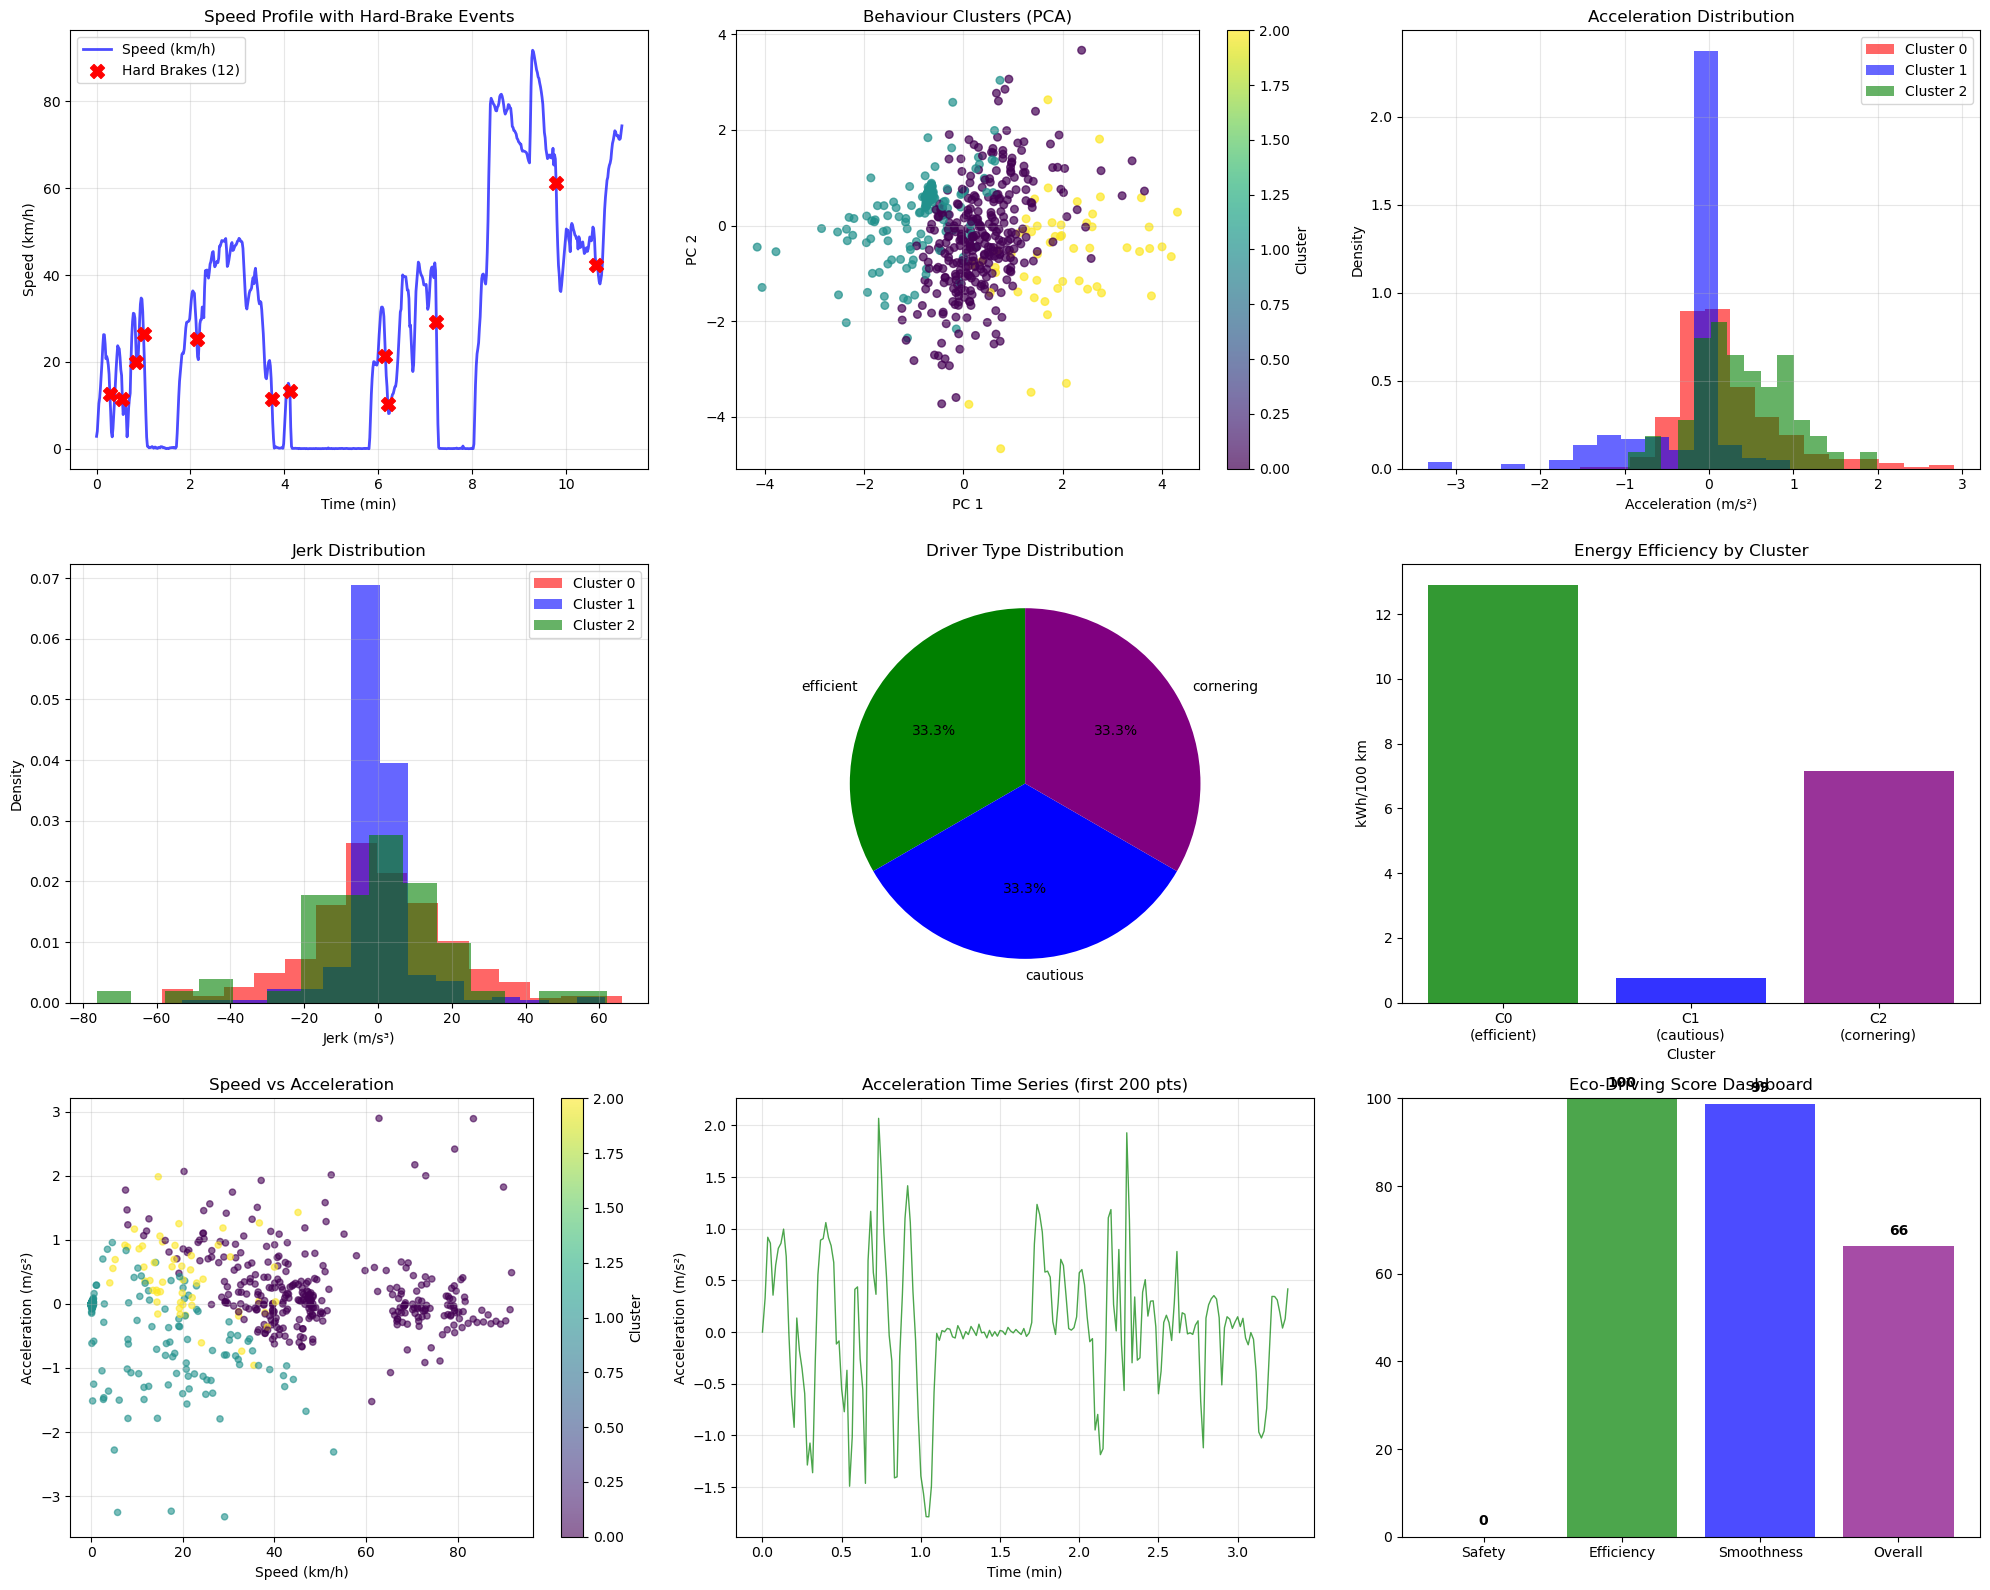

2025-05-28 02:41:54,998 - INFO - Results saved to eco_driving_results


Step 6: Saving outputs
Analysis complete!


: 

: 

: 

In [ ]:
if __name__ == "__main__":
    DATA_FILE = "ts_1747221572.csv"

    STARTUP_CONFIG = {
        "hard_brake_threshold": -2.0,
        "speed_drop_threshold": 6,
        "min_brake_speed": 8,
        "energy_model": {
            "vehicle_mass": 1600,
            "drag_coefficient": 0.26,
            "frontal_area": 2.2,
            "rolling_resistance": 0.010,
        },
        "clustering": {
            "n_clusters": 3,
            "features": ["speed", "acceleration", "jerk", "turning_rate"],
        },
    }

    run_complete_eco_driving_analysis(DATA_FILE, STARTUP_CONFIG)